# Right-hand side vector power series approximation

Using [2] for reference, we try their approximation for the initialization of the right-hand side vector of the linear system $b$


In [1]:
import numpy as np
from typing import Optional
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from itertools import product
from IPython.display import display, Markdown, Latex, Math
from hhl_functions import *

In [2]:
size = 2
qr = QuantumRegister(size,name='q')
qa = AncillaRegister(1,name="a")
qc = QuantumCircuit(qr,qa)

for i in range(size):
    qc.h(i)
# p(x) = x^2 + x + 1

qc.ry(2*1,qa)
qc.cry(2*(4+2),qr[1],qa)
qc.cry(2*(1+1),qr[0],qa)
qc.mcry(2*4,qr[:],qa)

#qc.initialize(vector/np.linalg.norm(vector),range(2),None)

print(qc.draw())

st = Statevector(qc)

st.data.real[4:]

       ┌───┐                                                  
q_0: ──┤ H ├────────────────■───────────────■──────────────■──
       ├───┤                │               │              │  
q_1: ──┤ H ├──────■─────────┼───────────────■──────────────■──
     ┌─┴───┴─┐┌───┴────┐┌───┴───┐┌───────┐┌─┴─┐┌────────┐┌─┴─┐
  a: ┤ Ry(2) ├┤ Ry(12) ├┤ Ry(4) ├┤ Ry(4) ├┤ X ├┤ Ry(-4) ├┤ X ├
     └───────┘└────────┘└───────┘└───────┘└───┘└────────┘└───┘


array([0.42073549, 0.07056   , 0.3284933 , 0.21008352])

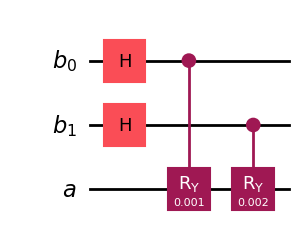

In [4]:
b = b_state(2,'x',0.001)
b.draw('mpl')

In [11]:
function = 'x^2+x'
size = 2
b = b_state(size,function,0.001)
state = Statevector(b)
state = state.data.real[2**size:]
state/np.linalg.norm(state)

array([1.12354231e-17, 1.47444802e-01, 4.42332048e-01, 8.84648173e-01])

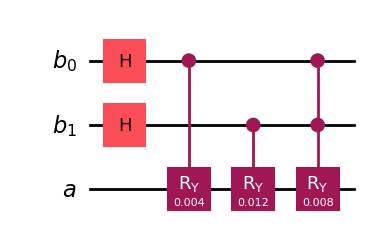

In [12]:
b.draw('mpl')

In [13]:
arr = np.array(b_from_func(function,2**size))
qc = QuantumCircuit(size)
qc.initialize(arr/np.linalg.norm(arr))
state = Statevector(qc)
print(state.data.real)

[0.         0.19069252 0.47673129 0.85811633]


As we can see, we get good results by approximating (except when we include an amplitude a $_0$). This approximation includes an error and an extra ancilla, so we need to test its effectiveness. To do that, we can resolve to make an study of the number of gates, similar to what we did with the HHL circuit.

In [38]:
function = 'x^2+x'
gates1={}
gates2={}
diff_1 = []
for i in range(1,12):
    print(f'Iteration {i}.1, size: {2**i}')
    b = b_state(i,function,10e-8)
    gates1[i] = b.decompose(reps=6).size()
    state = Statevector(b)
    state = state.data.real[2**i:]
    sol1=state/np.linalg.norm(state)
    ########### Second circuit
    print(f'Iteration {i}.2')
    arr = np.array(b_from_func(function,2**i))
    qc = QuantumCircuit(i)
    qc.initialize(arr/np.linalg.norm(arr))
    gates2[i] = qc.decompose(reps=6).size()    
    state = Statevector(qc).data.real
    diff_1.append(np.linalg.norm(np.abs(state-sol1))/2**i)
    
print(f'The number of gates of the approximation approach is {gates1}')
print(f'The number of gates of the exact approach is {gates2}')
print(f'The difference array is {diff_1}')

Iteration 1.1, size: 2
Iteration 1.2
Iteration 2.1, size: 4
Iteration 2.2
Iteration 3.1, size: 8
Iteration 3.2
Iteration 4.1, size: 16
Iteration 4.2
Iteration 5.1, size: 32
Iteration 5.2
Iteration 6.1, size: 64
Iteration 6.2
Iteration 7.1, size: 128
Iteration 7.2
Iteration 8.1, size: 256
Iteration 8.2
Iteration 9.1, size: 512
Iteration 9.2
Iteration 10.1, size: 1024
Iteration 10.2
Iteration 11.1, size: 2048
Iteration 11.2
The number of gates of the approximation approach is {1: 5, 2: 42, 3: 159, 4: 457, 5: 1175, 6: 2892, 7: 7015, 8: 16943, 9: 40791, 10: 97650, 11: 231751}
The number of gates of the exact approach is {1: 2, 2: 7, 3: 16, 4: 33, 5: 50, 6: 67, 7: 84, 8: 101, 9: 118, 10: 135, 11: 152}
The difference array is [0.0, 0.01532659502272172, 0.03384732860524003, 0.02798039761860354, 0.0180793575287153, 0.010560340413306828, 0.005867458420959174, 0.003159967599424082, 0.0014863771038959163, 0.0007556980681267271, 0.0005159924728461602]


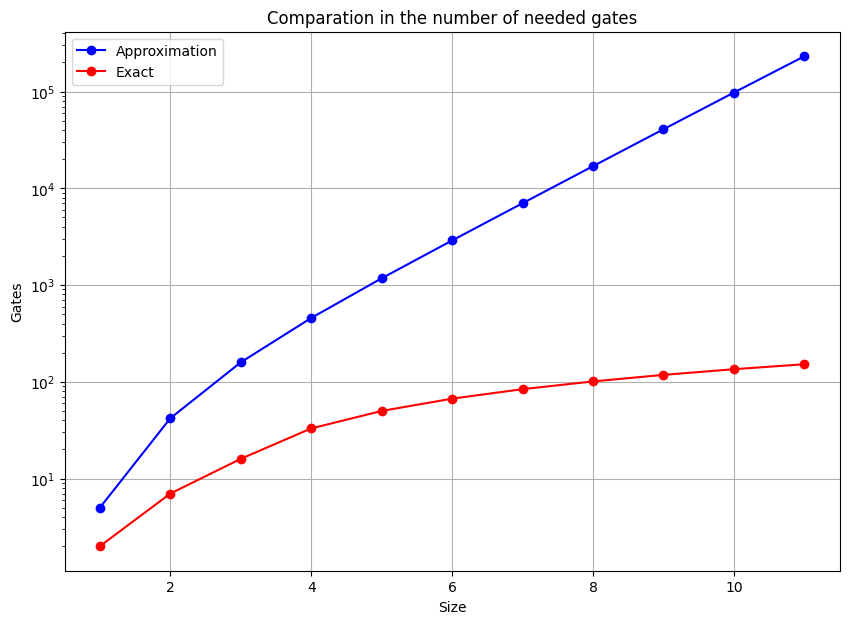

In [39]:
import matplotlib.pyplot as plt

keys_1 = list(gates1.keys())
values_1 = list(gates1.values())
keys = list(gates2.keys())
values = list(gates2.values())

plt.figure(figsize=(10, 7))

plt.plot(keys_1, values_1, marker='o', linestyle='-', color='blue')
plt.plot(keys, values, marker='o', linestyle='-', color='red')
plt.xlabel('Size')
plt.ylabel('Gates')
plt.yscale('log')
plt.title('Comparation in the number of needed gates')
plt.legend(['Approximation','Exact'])
plt.grid(True)
plt.show()

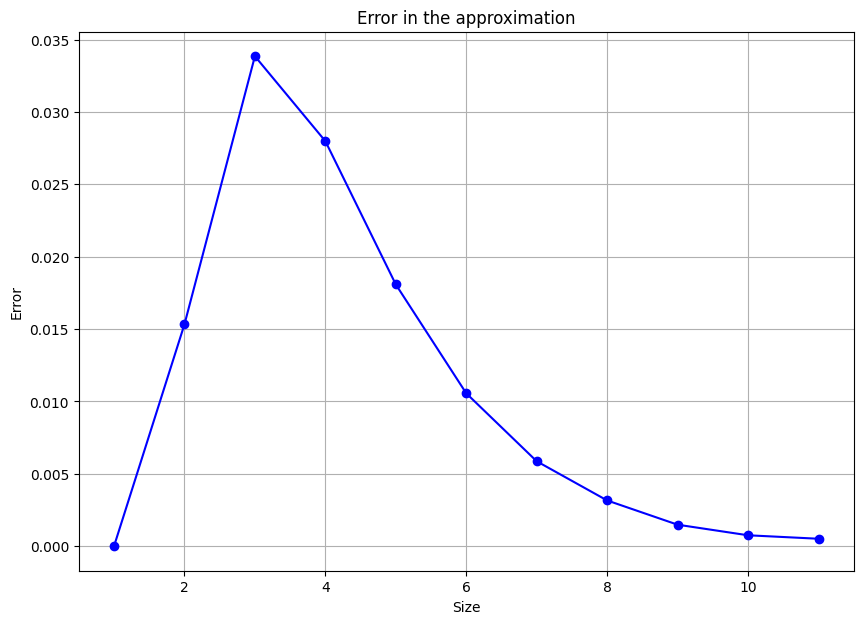

In [40]:
import matplotlib.pyplot as plt

x = np.arange(1,12,1)
plt.figure(figsize=(10, 7))

# for i in range(len(diff)):
#     diff[i]=diff[i]*2**i

plt.plot(x, diff_1, marker='o', linestyle='-', color='blue')
plt.xlabel('Size')
plt.ylabel('Error')
plt.title('Error in the approximation')
plt.grid(True)
plt.show()

Using Lagrange interpolation, we can get an analytic expression for the MSE function. Then we can do it for some other initilization functions and see if we get any matches. This way we can extract an approximate error function for this approach.

In [11]:
from scipy.interpolate import lagrange
import sympy as sp

poly = lagrange(x, diff_1)

# Convert to a sympy expression for an analytic expression
x_sym = sp.symbols('x')
poly_expr = sum(round(float(c),3) * x_sym**i for i, c in enumerate(poly.coefficients[::-1]))

print("Lagrange Interpolation Polynomial:")
print(poly_expr)

Lagrange Interpolation Polynomial:
-0.001*x**7 + 0.006*x**6 - 0.043*x**5 + 0.204*x**4 - 0.638*x**3 + 1.213*x**2 - 1.213*x + 0.471


In [41]:
function = 'x^3+3x^2-5x'
gates1={}
gates2={}
diff_2 = []
for i in range(1,10):
    print(f'Iteration {i}.1, size: {2**i}')
    b = b_state(i,function,10e-8)
    gates1[i] = b.decompose(reps=6).size()
    state = Statevector(b)
    state = state.data.real[2**i:]
    sol1=state/np.linalg.norm(state)
    ########### Second circuit
    print(f'Iteration {i}.2')
    arr = np.array(b_from_func(function,2**i))
    qc = QuantumCircuit(i)
    qc.initialize(arr/np.linalg.norm(arr))
    gates2[i] = qc.decompose(reps=6).size()    
    state = Statevector(qc).data.real
    diff_2.append(np.linalg.norm(np.abs(state-sol1))/2**i)
    
print(f'The number of gates of the approximation approach is {gates1}')
print(f'The number of gates of the exact approach is {gates2}')

Iteration 1.1, size: 2
Iteration 1.2
Iteration 2.1, size: 4
Iteration 2.2
Iteration 3.1, size: 8
Iteration 3.2
Iteration 4.1, size: 16
Iteration 4.2
Iteration 5.1, size: 32
Iteration 5.2
Iteration 6.1, size: 64
Iteration 6.2
Iteration 7.1, size: 128
Iteration 7.2
Iteration 8.1, size: 256
Iteration 8.2
Iteration 9.1, size: 512
Iteration 9.2
The number of gates of the approximation approach is {1: 5, 2: 42, 3: 159, 4: 457, 5: 1175, 6: 2892, 7: 7015, 8: 16943, 9: 40791}
The number of gates of the exact approach is {1: 3, 2: 10, 3: 25, 4: 56, 5: 87, 6: 118, 7: 149, 8: 180, 9: 211}


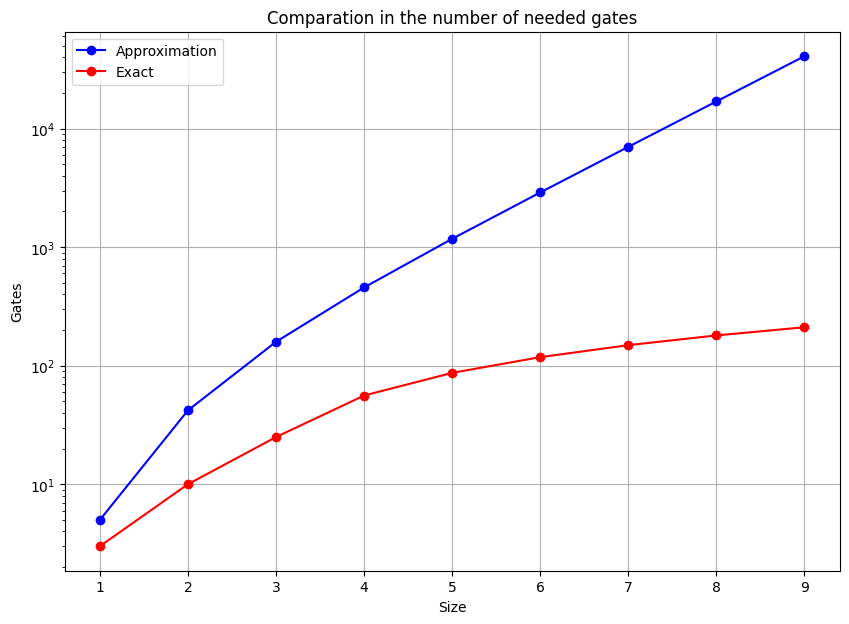

In [41]:
import matplotlib.pyplot as plt

keys_1 = list(gates1.keys())
values_1 = list(gates1.values())
keys = list(gates2.keys())
values = list(gates2.values())

plt.figure(figsize=(10, 7))

plt.plot(keys_1, values_1, marker='o', linestyle='-', color='blue')
plt.plot(keys, values, marker='o', linestyle='-', color='red')
plt.xlabel('Size')
plt.ylabel('Gates')
plt.yscale('log')
plt.title('Comparation in the number of needed gates')
plt.legend(['Approximation','Exact'])
plt.grid(True)
plt.show()

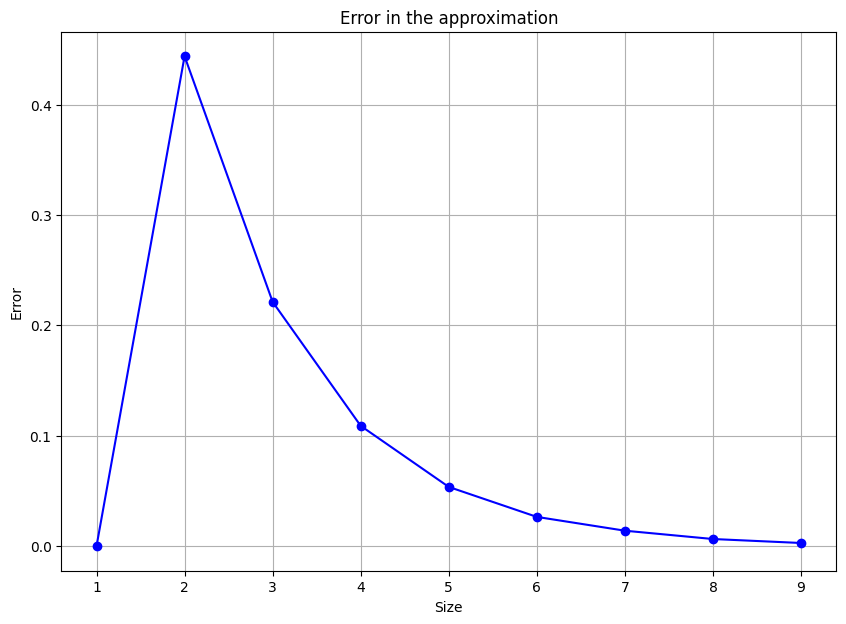

In [42]:
import matplotlib.pyplot as plt

x = np.arange(1,10,1)
plt.figure(figsize=(10, 7))

plt.plot(x, diff_2, marker='o', linestyle='-', color='blue')
plt.xlabel('Size')
plt.ylabel('Error')
plt.title('Error in the approximation')
plt.grid(True)
plt.show()

In [22]:
from scipy.interpolate import lagrange
import sympy as sp

poly = lagrange(x, diff_2)

# Convert to a sympy expression for an analytic expression
x_sym = sp.symbols('x')
poly_expr = sum(float(c) * x_sym**i for i, c in enumerate(poly.coefficients[::-1]))

print("Lagrange Interpolation Polynomial:")
print(poly_expr)

Lagrange Interpolation Polynomial:
-2.08939822021939e-5*x**8 + 0.000923003409430392*x**7 - 0.0173899623373943*x**6 + 0.182072788905938*x**5 - 1.15498386101907*x**4 + 4.52331000316471*x**3 - 10.5789540051212*x**2 + 13.1816079094762*x - 6.13656498249648


We can improve the fitting of the interpolation using other functions. To do that, first, we have to remove the first factors, because they don't follow the norm of the other ones. Then we can apply the fitting. Based on the looks of the function, we can assume that it must be one of these two types:
- An exponential function: $a+be^{-cx}$
- An inverse function: $a+\frac{b}{x^c}$

We define the functions and then run the scipy function `curve_fit`

In [110]:
from scipy.optimize import curve_fit

def func1(x, a, b, c):
    return a * np.exp(-b * x) + c

def func2(x,a,b,c):
    return a + b/(x**c)

x1 = np.arange(4,12,1)
x2 = np.arange(4,10,1)

diff_1 = np.array(diff_1)
diff_2 = np.array(diff_2)

# Only to use the first time
# diff_1 = diff_1[3:]
# diff_2 = diff_2[3:]

popt1,pcov1 = curve_fit(func1,x1,diff_1,p0=[1.0, 0.1, 1.0])

popt2,pcov2 = curve_fit(func2,x1,diff_1)

popt3,pcov3 = curve_fit(func1,x2,diff_2,p0=[1.0, 0.1, 1.0])

popt4,pcov4 = curve_fit(func2,x2,diff_2)

print('-FUNCTION 2')
print(f'The parameters using the exponential function are: {popt1}')
print(f'The parameters using the inverse function are: {popt2}')
print(f'---------------------------------------------------------------------\n-FUNCTION 2')
print(f'The parameters using the exponential function are: {popt3}')
print(f'The parameters using the inverse function are: {popt4}')

-FUNCTION 2
The parameters using the exponential function are: [ 0.18688967  0.46222365 -0.00113862]
The parameters using the inverse function are: [-0.00562629  0.44067819  1.84700165]
---------------------------------------------------------------------
-FUNCTION 2
The parameters using the exponential function are: [1.81204073e+00 7.03039041e-01 5.54302824e-05]
The parameters using the inverse function are: [-0.00883663  6.7020401   2.91361774]


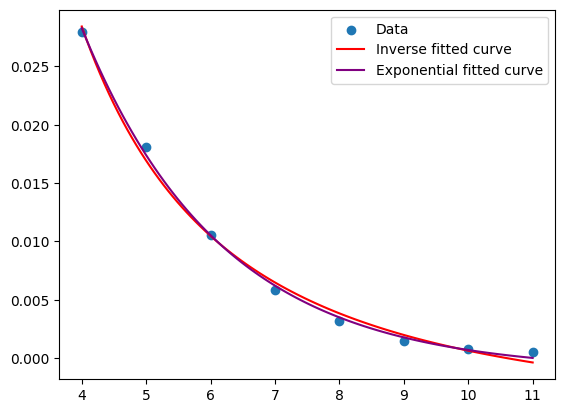

In [111]:
plt.scatter(x1, diff_1, label='Data')
x = np.linspace(4,11,100)
plt.plot(x, func2(x, *popt2), label='Inverse fitted curve', color='red')
plt.plot(x, func1(x, *popt1), label='Exponential fitted curve', color='purple')
plt.legend()
plt.show()

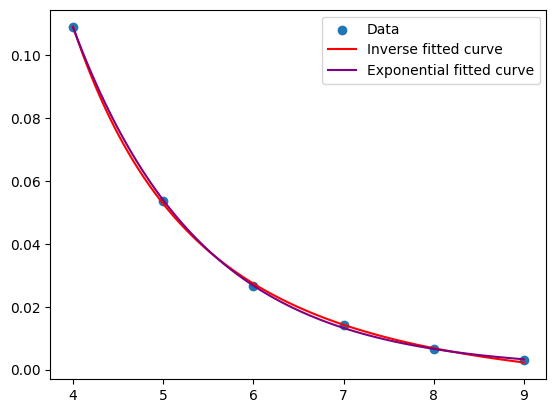

In [112]:
plt.scatter(x2, diff_2, label='Data')
x = np.linspace(4,9,100)
plt.plot(x, func2(x, *popt4), label='Inverse fitted curve', color='red')
plt.plot(x, func1(x, *popt3), label='Exponential fitted curve', color='purple')
plt.legend()
plt.show()

As we can see, the fitting is really good with both functions, but the exponential approach seems to work better for the seeming evolution. With this, we can deduce that the profile of the MSE is a negative exponential. This is really good, as it implies a good approximation when the size of the problem increases.

With this study finished we can start importing this approximation into the HHL algorithm as the initialization of the right-hand side vector

---

## Implementation for HHL

To do this, we will include a new optional argument in the function, that indicates the function mapping the right-hand side vector of the approximation. As the paper [2] indicates, the $c$ is going to be chosen as $\sqrt{\varepsilon_p}$, depending in the tolerance of the whole algorithm.

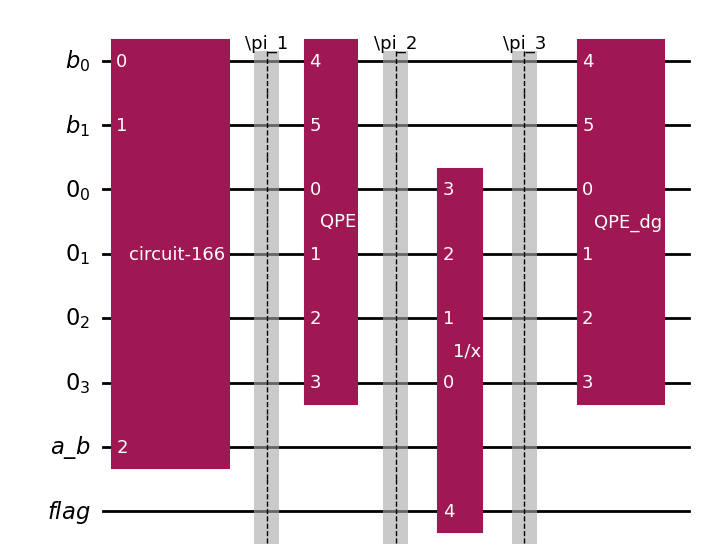

In [2]:
vector = 2
matrix=tridiag_matrix(2,-1,4)
hhl = HHL(matrix,vector,fnc='x')
hhl.qc.draw('mpl')

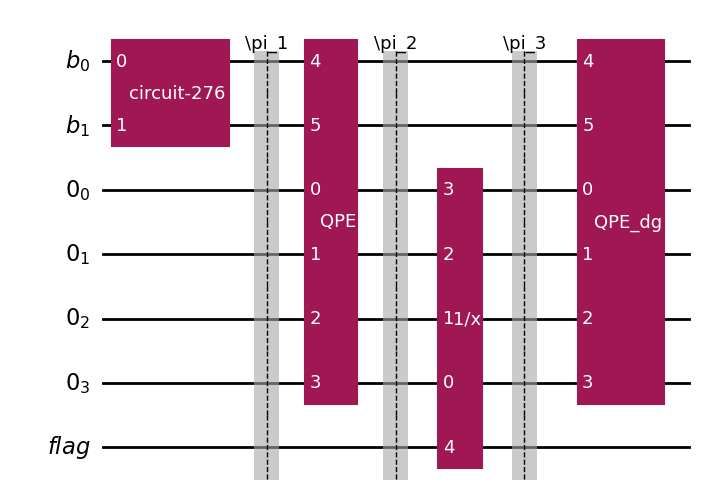

In [3]:
vector = np.array(b_from_func('x',4))
matrix = tridiag_matrix(2,-1,4)
hhl2 = HHL(matrix,vector,flag=True)
hhl2.qc.decompose(reps=0).draw('mpl')

In [15]:
st = Statevector(hhl.qc).data.real
num = int(len(st)/2)+64
st = st[192:196]
print('Solución con HHL (aproximado):\t',st/np.linalg.norm(st))
print('Solución con HHL:\t\t',hhl2.solution())
s=np.linalg.solve(matrix,np.array(b_from_func('x',4)))
print('Solución real:\t\t\t',s/np.linalg.norm(s))

Solución con HHL (aproximado):	 [0.25540959 0.51306228 0.63945808 0.51247089]
Solución con HHL:		 [0.25540959 0.51306227 0.63945808 0.51247089]
Solución real:			 [0.25607376 0.51214752 0.6401844  0.51214752]


In [31]:
hhl2.solution()

array([0.39206738, 0.5884583 , 0.5884583 , 0.39206738])

In [32]:
s=np.linalg.solve(matrix,np.array(b_from_func('x',4)))
s/np.linalg.norm(s)

array([0.25607376, 0.51214752, 0.6401844 , 0.51214752])

Now we know that this works with statevectors, but we have to try with shots, that are the solutions we get from a real QPU

In [9]:
def ampl_from_sim(qc,shots=8192):
    sim = AerSimulator()
    qc.measure_all()
    qc = transpile(qc,sim)
    sampler = SamplerV2()
    
    nb = qc.qregs[0].size
    nl = qc.qregs[1].size

    job = sampler.run([qc],shots=shots)
    job_result = job.result()
    counts=job_result[0].data.meas.get_counts()

    all_outcomes = [''.join(outcome) for outcome in product('01', repeat=nb+nl+1+1)]

    prob = []
    for elem in all_outcomes:
        if elem in counts:
            prob.append(counts[elem]/shots)
        else:
            prob.append(0)
    prob = np.array(prob)
    prob = np.sqrt(prob)
    return prob

We got a **big problem** here. With the actual approach the amplitudes of the values of the solution where the ancilla qubit is 0 are really small. With this in hand, we dont get any shot that measures this values. We need a way to make the probabilities of measuring a 1 much higher. 

Using [2] as a base, due to the implementation, we have that the probability of measuring $|1>$ in the ancilla qubit must be higher than $\frac{c^2}{C_b^2}-c^4$, then

In [215]:
epsilon_s = 10e-3
Cb = 0.9
c = epsilon_s/(8*Cb)


prob = c**2/Cb**2-c**4
display(Markdown(f'#### The probability must be higher than {prob}'))

#### The probability must be higher than 2.381493001971879e-06

We can test this:

In [210]:
st = Statevector(hhl.qc)
st = st.data.real
num = int(len(st)/2) + 64
for i in range(4):
    print(st[num+i]>prob)

True
True
True
True


To improve this probability we can increase the value of $c$, but by doing this, the error of the solution worsens. If we want to achieve a good solution we need to make a compromise. This is increasingly important if we want to make the measurements of the circuit by shots.

In [7]:
vector = 2
matrix=tridiag_matrix(2,-1,2**vector)
hhl_bigc = HHL(matrix,vector,fnc='x')

In [248]:
st = Statevector(hhl_bigc.qc)
st = st.data.real
num = int(len(st)/2) + 64
sol = []
for i in range(4):
    sol.append(st[num+i])
sol = sol/np.linalg.norm(sol)
sol

array([0.255, 0.513, 0.639, 0.512])

## Study of the probabilities of the solution and $c$

We can study how the value of $c$ influences the probabilities of measuring the real solution to the problem

In [21]:
vector = 2
matrix=tridiag_matrix(2,-1,2**vector)

arr = [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.25,0.5,0.75,1]

# Analytic solution
s=np.linalg.solve(matrix,np.array(b_from_func('x^2',4)))
s=s/np.linalg.norm(s)

norm = []
prob = {}
diff = []

for c in arr:
    hhl = HHL(matrix,vector,fnc='x^2-x',c=c)
    st = Statevector(hhl.qc).data.real[192:196] **2
    norm.append(np.linalg.norm(st))
    prob[c] = st
    diff.append(st/np.linalg.norm(st)-s)
    

In [22]:
norm

[1.951168737190339e-10,
 4.877921741144161e-09,
 1.9511685691680628e-08,
 4.877911239761996e-07,
 1.9511517670074997e-06,
 4.876861206514848e-05,
 0.00019494722226332916,
 0.004772901441201985,
 0.017880794758143137,
 0.07000970175867947,
 0.05025835700708324,
 0.01532001777879819,
 0.034735346969986536]

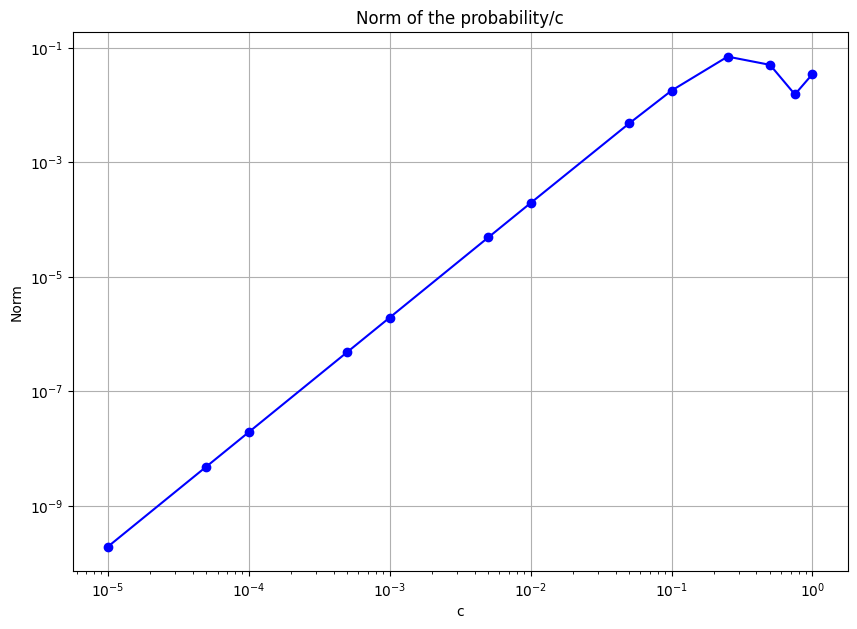

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.plot(arr, norm, marker='o', linestyle='-', color='blue')
plt.xlabel('c')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Norm')
plt.title('Norm of the probability/c')
plt.grid(True)
plt.show()

Seeing that we get a linear evolution in [$10^{-5}$,$0.1$], we can study more in depth what happens in [$0.1,1$]

In [28]:
vector = 2
matrix=tridiag_matrix(2,-1,2**vector)

arr = np.linspace(0.1,1,100)

function = 'x^2-x'

# Analytic solution
s=np.linalg.solve(matrix,np.array(b_from_func('x',4)))
s=s/np.linalg.norm(s)

norm = []
diff = []

for c in arr:
    hhl = HHL(matrix,vector,fnc=function,c=c)
    st = Statevector(hhl.qc).data.real[192:196]
    prob = st**2
    # st is now the probability
    norm.append(np.linalg.norm(prob))
    diff.append(st/np.linalg.norm(st)-s)

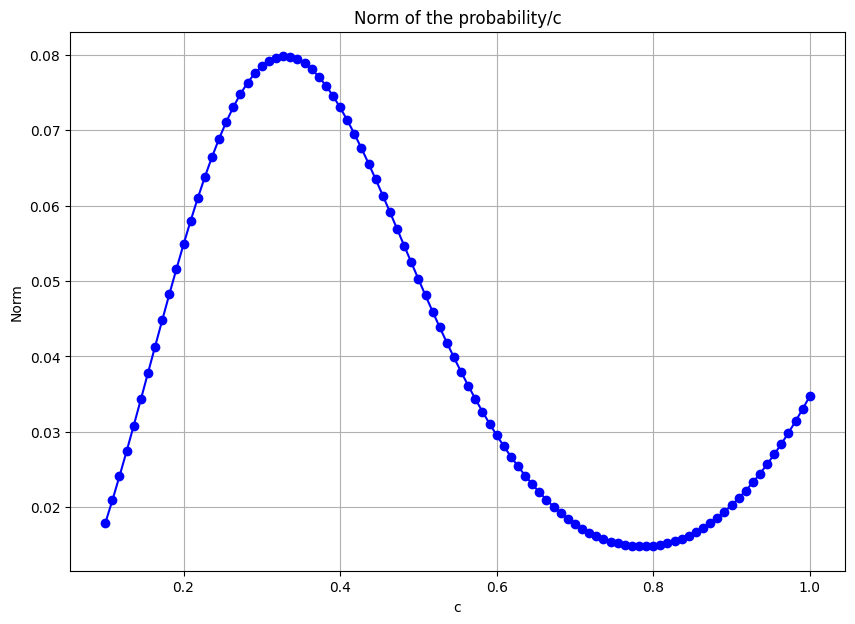

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.plot(arr, norm, marker='o', linestyle='-', color='blue')
plt.xlabel('c')
plt.ylabel('Norm')
plt.title('Norm of the probability/c')
plt.grid(True)
plt.show()

In [32]:
line1 = []
line2 = []
line3 = []
line4 = []

for elem in diff:
    line1.append(elem[0])
    line2.append(elem[1])
    line3.append(elem[2])
    line4.append(elem[3])

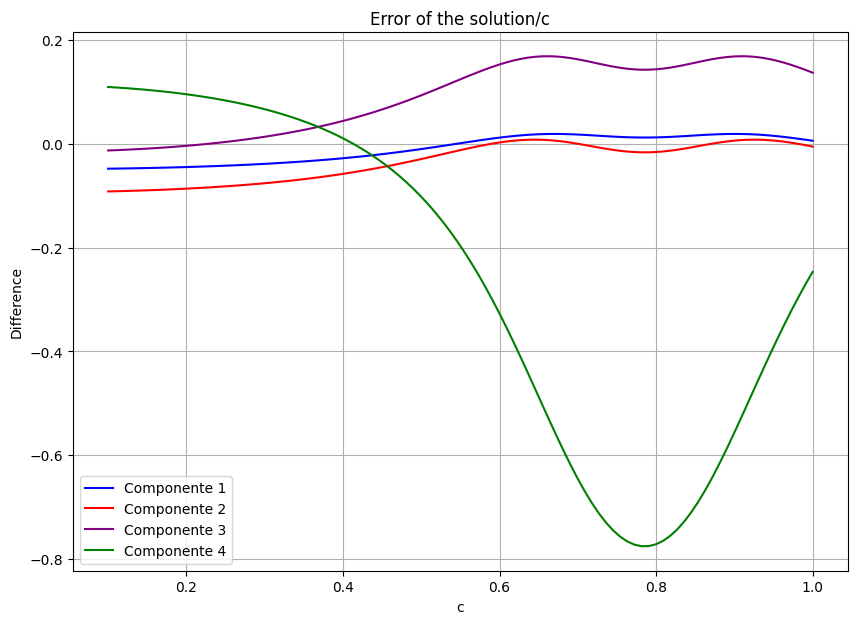

In [37]:
plt.figure(figsize=(10, 7))

plt.plot(arr, line1, linestyle='-', color='blue')
plt.plot(arr, line2, linestyle='-', color='red')
plt.plot(arr, line3, linestyle='-', color='purple')
plt.plot(arr, line4, linestyle='-', color='green')

plt.xlabel('c')
plt.ylabel('Difference')
plt.title('Error of the solution/c')
plt.legend(['Componente 1','Componente 2','Componente 3','Componente 4'])
plt.grid(True)
plt.show()

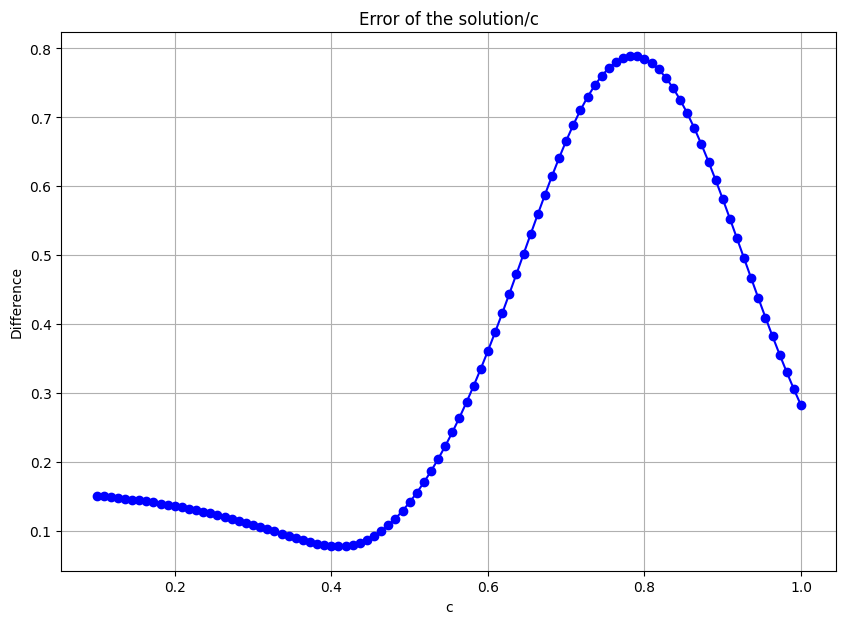

In [31]:
plt.figure(figsize=(10, 7))

norma = [np.linalg.norm(diff[i]) for i in range(len(diff))]

plt.plot(arr, norma, marker='o', linestyle='-', color='blue')
plt.xlabel('c')
plt.ylabel('Difference')
plt.title('Error of the solution/c')
plt.grid(True)
plt.show()

## Fourier analysis

Given the shape of the norm of the probability, it seems it comes from a Fourier series. To get more information from this, we can make a Fourier analysis to get the waves that generate this functions.

Picos en: [ 2  6  9 13 15 22 25 28 33 37 40 43]


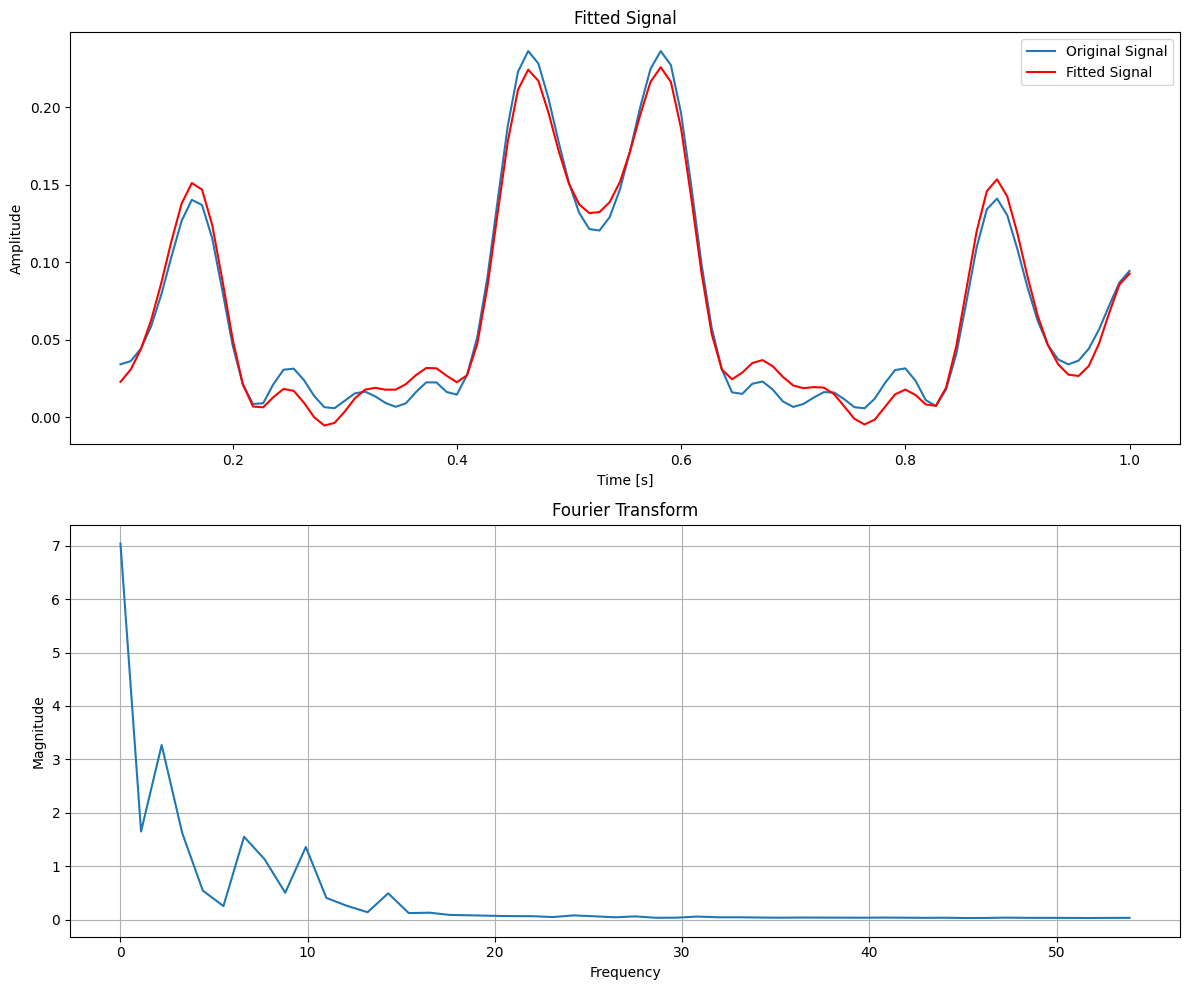

Fitted Parameters (Amplitude, Frequency, Phase):
Cosine 1: Amplitude = 0.08, Frequency = 2.47 Hz, Phase = -1.86 radians
Cosine 2: Amplitude = 0.04, Frequency = 7.24 Hz, Phase = -1.82 radians
Cosine 3: Amplitude = -0.03, Frequency = 9.46 Hz, Phase = 0.32 radians
Cosine 4: Amplitude = -0.01, Frequency = 14.34 Hz, Phase = -0.08 radians
Cosine 5: Amplitude = 0.11, Frequency = 0.58 Hz, Phase = -121.31 radians
Function:


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

array([ 8.20893049e-02,  2.47255274e+00, -1.86183296e+00,  3.94458623e-02,
        7.24431788e+00, -1.82033670e+00, -3.03435120e-02,  9.45958745e+00,
        3.19893586e-01, -1.21848677e-02,  1.43400463e+01, -8.48260671e-02,
        1.06830501e-01,  5.84576967e-01, -1.21314626e+02])

In [6]:
fourier_error_analysis(arr,norm,n_peaks=5)

Picos en: [ 2  7 11 13 15 17 20 22 29 32 34 37 40 44]


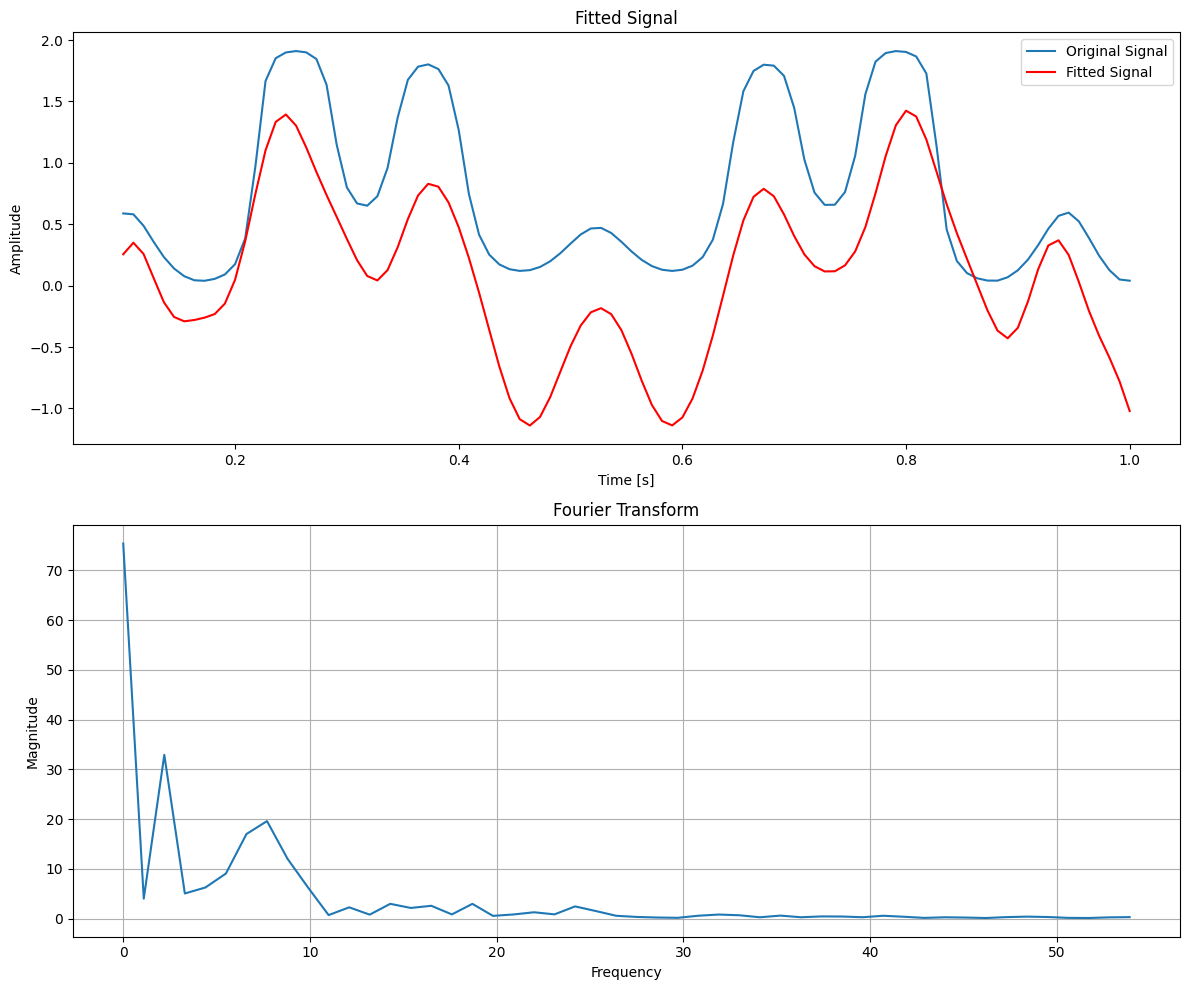

Fitted Parameters (Amplitude, Frequency, Phase):
Cosine 1: Amplitude = -0.78, Frequency = 1.98 Hz, Phase = -0.30 radians
Cosine 2: Amplitude = 0.61, Frequency = 7.14 Hz, Phase = 1.51 radians
Cosine 3: Amplitude = -5.21, Frequency = 15.18 Hz, Phase = -5.31 radians
Cosine 4: Amplitude = 5.20, Frequency = 15.17 Hz, Phase = -5.28 radians
Function:


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

array([-0.78219193,  1.98118345, -0.30038663,  0.60539296,  7.14068417,
        1.50965959, -5.20540909, 15.17740008, -5.31423833,  5.20151262,
       15.16709921, -5.27922529])

In [7]:
from matplotlib.ticker import MaxNLocator
fourier_error_analysis(arr,norma,n_peaks=4)